In [1]:
import sys, os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

import pydicom
from pydicom.data import get_testdata_files

from scipy import stats

## Image Loading

Façamos o carregamento das imagens do treino e teste a serem utilizadas na análise dos dados.

In [2]:
np.random.seed(11)

# --- Loading images ---
filenames = []
imgs = []
for filename in os.listdir("train_images"):
    filenames.append( filename.replace("-c.dcm", "").replace(".dmc","") )
    imgs.append( pydicom.dcmread("train_images/"+filename).pixel_array )

imgs = np.array(imgs)

imgs_ind = np.arange(imgs.shape[0])
test_ind = np.random.choice(imgs_ind, 300, replace = False)
train_ind = np.array(list(set(imgs_ind) - set(test_ind)))

train_imgs = imgs[train_ind,:,:]
test_imgs = imgs[test_ind,:,:]

In [3]:
# --- Get train image labels ---
labels = pd.read_csv("train.csv")
keys = list(labels.iloc[:,0])
values = np.array([name.split()[0] for name in list(labels.iloc[:,1])]).astype(int)

file_to_class = dict(zip(keys, values))
labels_codes = np.array([file_to_class.get(filename) for filename in filenames])

bodyparts = {0:'Abdomen', 1:'Ankle', 2:'Cervical Spine', 3:'Chest', 4:'Clavicles', 5:'Elbow',
             6:'Feet' ,7 : 'Finger' ,8 : 'Forearm' ,9 : 'Hand' ,10 : 'Hip' ,11 : 'Knee',
             12: 'Lower Leg', 13 : 'Lumbar Spine' ,14 : 'Others' ,15 :'Pelvis',16 :'Shoulder',
             17:'Sinus', 18:'Skull', 19 : 'Thigh' ,20 :'Thoracic Spine',21: 'Wrist'}

train_labels = labels_codes[train_ind]
train_label_names = np.array([bodyparts[label] for label in train_labels])

test_labels = labels_codes[test_ind]
test_label_names = np.array([bodyparts[label] for label in test_labels])

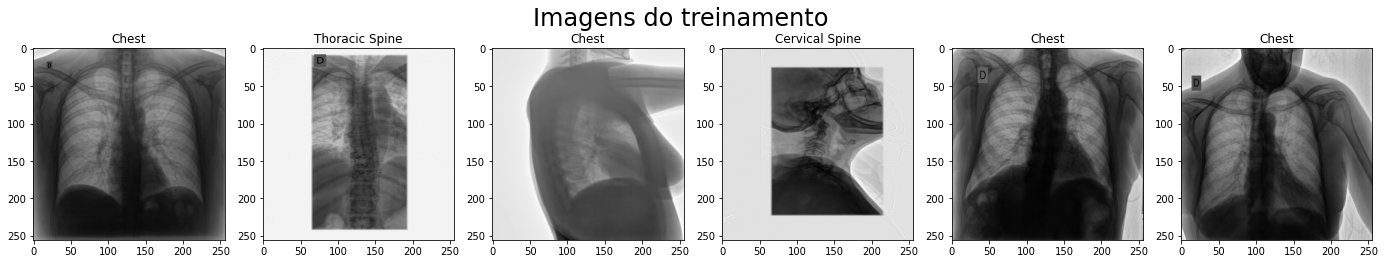

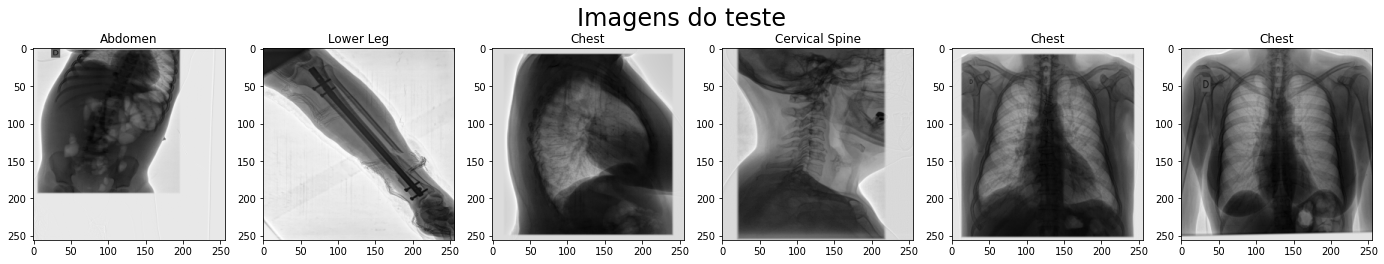

In [4]:
np.random.seed(11)

train_plot_ind = np.random.choice(np.arange(len(train_labels)), 6, replace = False)
test_plot_ind = np.random.choice(np.arange(len(test_labels)), 6, replace = False)

fig1, ax1 = plt.subplots(nrows = 1, ncols = 6, figsize = (24,4))
fig2, ax2 = plt.subplots(nrows = 1, ncols = 6, figsize = (24,4))

for j in range(len(train_plot_ind)):
    ax1[j].imshow( train_imgs[ train_plot_ind[j] ], cmap = "gray" )
    ax1[j].set_title( train_label_names[ train_plot_ind[j] ] )
    ax2[j].imshow( test_imgs[ test_plot_ind[j] ], cmap = "gray" )
    ax2[j].set_title( test_label_names[ test_plot_ind[j] ] )

fig1.suptitle("Imagens do treinamento", fontsize=24)
fig2.suptitle("Imagens do teste", fontsize=24)
plt.show()

In [5]:
def normalize(img, a = 0, b = 255):
    '''
        Normaliza a imagem no intervalo especificado.
        
        Parâmetros
        ----------
        img: ndarray
                Imagem a ser normalizada.
        a: int 
                limite inferior da normalização. 
        b: int
                limite superior da normalização.
    '''
    img = img.astype(float)
    
    imax = np.max(img)
    imin = np.min(img)
    
    if(imin == imax):
        np.ones(shape = img.shape) * a
    
    img = (img - imin) / (imax - imin) * b
    return img

Façamos a normalização de todas as imagens tratadas para o intervalo inteiro $[0, 255]$.

In [6]:
# --- Normalize all images ---
train_imgs = np.array([normalize(train_imgs[j]).astype(np.uint8) for j in range(train_imgs.shape[0])])
test_imgs = np.array([normalize(test_imgs[j]).astype(np.uint8) for j in range(test_imgs.shape[0])])

Para fazermos o preprocessamento das imagens consideramos a seguinte função de transformação.

# Contrast Solving

É interessante destacarmos que as imagens geradas por raio-X parecem não apresentar um bom contraste de cores, mapeando a pele e os ossos a cores muito próximas. Com isso em mente, pensamos que seria interessante a aplicação de métodos de correção de contraste. A função a seguir se trata de uma ideia inicial para identificarmos qual o melhor método de correção de contraste para esses dados em específico.

## Função Linear

A primeira função implementada para testarmos a manipulação das  imagens segundo o contraste foi uma função linear separada em três partes, das quais definimos dois pontos de corte, $(z_1, w_1)$ e $(z_2, w_2)$. A função $f$ é contínua e tal que $f(0) = 0$ e $f(255) = 255$.

In [7]:
def contrast_function(x, z1, w1, z2, w2):
    X = x.copy()
    
    y = x.copy()
    y[X <= z1] = w1/z1 * x[X <= z1]
    y[ (z1 < X) & (X <= z2) ] = (w1-w2)/(z1-z2) * x[ (z1 < X) & (X <= z2) ] + w1 - (w1-w2)/(z1-z2) * z1
    y[X > z2] = (255 - w2)/(255 - z2) * x[X > z2] + 255*(1 - (255 - w2)/(255 - z2))
    
    return y

A função define uma transformação linear por partes das intensidades dos pixels, possibilitando o mapeamento de um pequeno intervalo de pixels a um intervalo maior, aumentando assim o contraste da imagem.

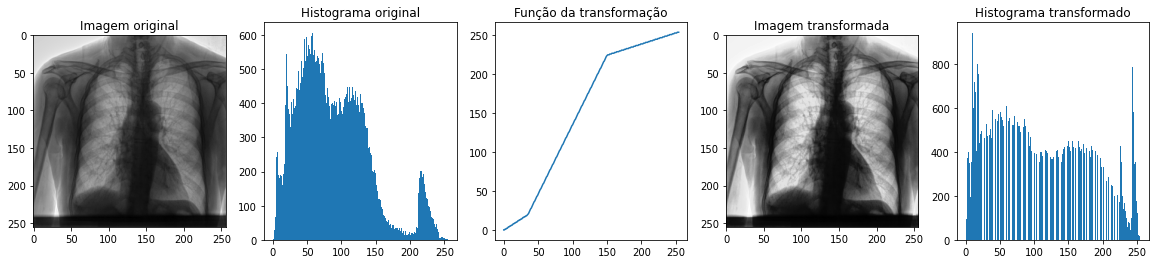

In [8]:
img = train_imgs[4]

z1, w1 = (35, 20)
z2, w2 = (150, 225)

# Aplica a correção de contraste especificada pelos pontos acima
img_contrast = contrast_function(img, z1, w1, z2, w2)

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,4))

ax[0].imshow(img, cmap = "gray")
ax[0].set_title("Imagem original")
ax[1].hist(img.flatten(), bins = 255)
ax[1].set_title("Histograma original")

x = np.arange(0, 255)
y = contrast_function(x, z1, w1, z2, w2)
ax[2].plot(x, y)
ax[2].set_title("Função da transformação")

ax[3].imshow(img_contrast, cmap = "gray")
ax[3].set_title("Imagem transformada")

ax[4].hist(img_contrast.flatten(), bins = 255)
ax[4].set_title("Histograma transformado")

plt.show()

Embora tenhamos realçado o contorno dos pulmões neste caso, os pontos especificados (50, 20) e (125, 225) podem não ser úteis para outras imagens, ou seja, seria necessária uma forma automática de encontrar os melhores parâmetros para cada imagem. Uma abordagem seria o uso de algoritmos de equalização por histograma, que identificam automaticamente a distribuição da imagem.

## Intervalos específicos de intensidade

In [9]:
def sliced_gray(I, A, B, L, method = 0, plot = True, ax = None):
    '''
        Executa um preprocessamento específico dependendo do método escolhido. Os métodos aplicados são:
        
        method = 0
            Retorna a própria imagem (função identidade).
        method = 1
            Retorna a imagem binarizada segundo um intervalo. Pixels com intensidade A < x < B são mapeados a 1
            e pixels fora dessa intervalo são mapeados para 0
        method = 2
            Retorna a imagem transformada de modo que pixels com intensidade A < x < B são mapeados para L enquanto
            pixels fora desse intervalo se mantém os mesmos.
        method = 3
            Retorna a imagem transformada segundo o method = 2, porém tomando o negativo da imagem previamente.
        
        Parâmetros
        ----------
        I: ndarray
                Imagem a ser transformada.
        A: int
                Limite inferior da transformação.
        B: int
                Limite superior da transformação.
        L: int
                Valor constante para o mapeamento dos métodos 1, 2 e 3.
        method: int
                Índice do método usado (0, 1, 2 ou 3).
        plot: bool
                Variável indicadora para a construção de um gráfico de intensidade.
        ax: matplotlib.axis
                Caso fornecido e plot = True, faz a plotagem da imagem no axis recebido.
    
        method = 0 : Original
        method = 1 : Binário
        method = 2 : Identity
        method = 3 : Negative
    '''
    img = I.copy()
    if(method == 1):
        img[(I >= A) & (I <= B)] = 255
        img[(I < A) | (I > B)] = 0
    elif(method == 2):
        img[(I >= A) & (I <= B)] = L
    elif(method == 3):
        img[(I >= A) & (I <= B)] = L
        img[(I < A) | (I > B)] = 255 - img[(I < A) | (I > B)]
    
    if(plot):
        x = np.arange(np.min(I), np.max(I), 1)
        y = x.copy()            
        if(method == 1):
            y[(x >= A) & (x <= B)] = 255
            y[(x < A) | (x > B)] = 0
        elif(method == 2):
            y[(x >= A) & (x <= B)] = L
        elif(method == 3):
            y[(x >= A) & (x <= B)] = L
            y[(x < A) | (x > B)] = 255 - y[(x < A) | (x > B)]
        
        if(ax is not None):
            ax.plot(x,y)
        else:
            plt.plot(x,y)
    
    return img

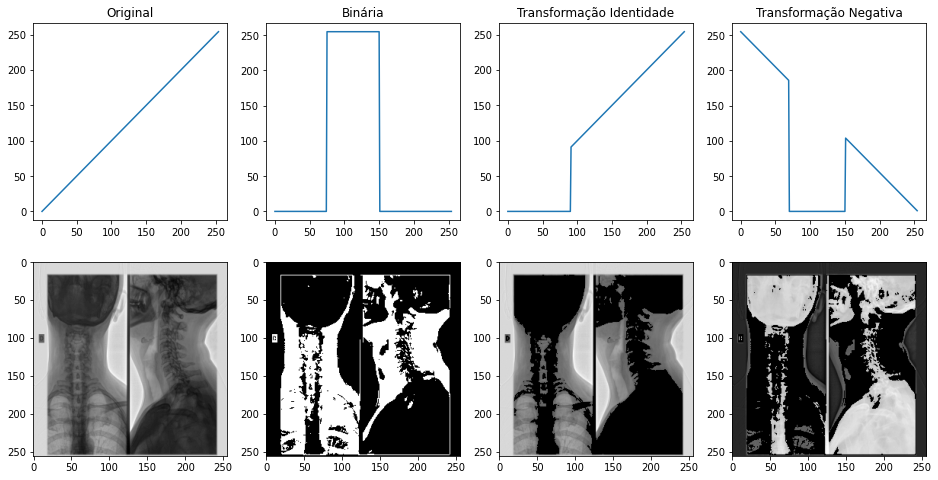

In [10]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16,8))

j = 0
img = train_imgs[j]

original_img = sliced_gray(img,  75, 150, 255, method = 0, plot = True, ax = ax[0,0])
binary_img = sliced_gray(img, 75, 150, 255, method = 1, plot = True, ax = ax[0,1])
identity_img = sliced_gray(img, 0, 90, 0, method = 2, plot = True, ax = ax[0,2])
negative_img = sliced_gray(img, 70, 150, 0, method = 3, plot = True, ax = ax[0,3])


ax[0,0].set_title("Original")
ax[1,0].imshow(original_img, cmap = "gray")

ax[0,1].set_title("Binária")
ax[1,1].imshow(binary_img, cmap = "gray")

ax[0,2].set_title("Transformação Identidade")
ax[1,2].imshow(identity_img, cmap = "gray")

ax[0,3].set_title("Transformação Negativa")
ax[1,3].imshow(negative_img, cmap = "gray")

plt.show()

Perceba que a função é capaz de separadar devidamente o osso e a pele do paciente. Um ponto negativo seria que dependendo da imagem pode ser necessária uma adaptação dos parâmetros da função, como os valores de A, B e L.

### Proposta

Percebemos que na maior parte das imagens o osso é levemente mais escuro que a pele do indivíduo, o que pode ser um ponto de início interessante para segmentarmos as imagens. De forma a tornar a transformação proposta acima mais adequada para as imagens, podemos utilizar uma abordagem quantílica, tomando os limites A e B segundo a distribuição das intensidades.

Essa adaptação pode ser essencial para abranger todo o conjunto de dados, uma vez que se uma imagem se encontra mais clara, os quantis detectados também seguirão esse padrão, garantindo que a informação dos ossos não será totalmente perdida. De modo a garantirmos um bom funcionamento dessa abordagem parece interessante aplicarmos a correção de contrastes previamente para depois encontrar esses quantis .

In [11]:
def quantile_transformation(I, plot = False, ax = None):
    '''
        A partir de uma imagem e do método escolhido, estima os limites A e B a serem utilizados pela função sliced_gray no método 2 com base
        na distribuição das intensidades da imagem, isto é, utilizando os quantis como limiares.
        
        Parâmetros
        ----------
        I: ndarray
                Imagem a ser transformada
    '''
    
    I_flat = I.flatten()
    
    # Como ossos são mais escuros no raio X procuramos passar pixels mais escuros para o valor 0, deixando os demais como estão
    A = 0
    B = np.quantile(I_flat, 0.25)
    L = 0
    
    return sliced_gray(I, A, B, L, 2, plot = plot, ax = ax)

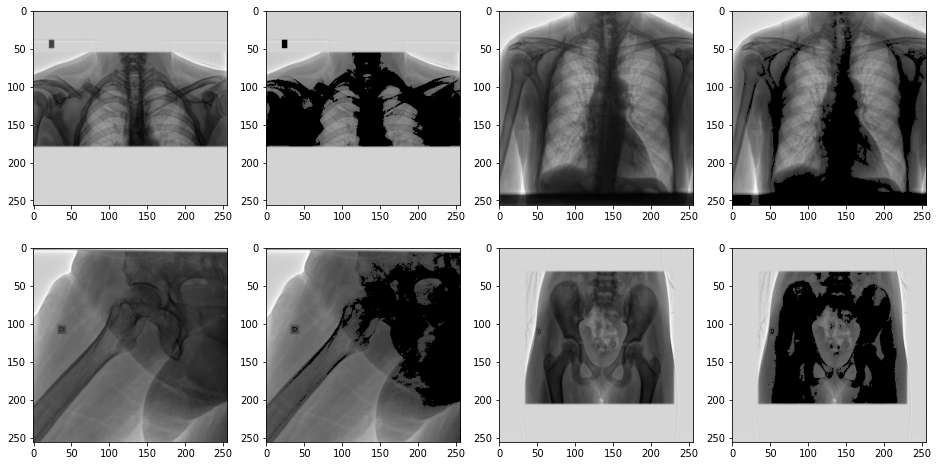

In [12]:
img1 = train_imgs[10]
img2 = train_imgs[4]
img3 = train_imgs[60]
img4 = train_imgs[152]

img_transformed1 = quantile_transformation(img1, plot = False)
img_transformed2 = quantile_transformation(img2, plot = False)
img_transformed3 = quantile_transformation(img3, plot = False)
img_transformed4 = quantile_transformation(img4, plot = False)

# Plota as imagens.
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16,8))

ax[0,0].imshow(img1, cmap = "gray")
ax[0,1].imshow(img_transformed1, cmap = "gray")

ax[0,2].imshow(img2, cmap = "gray")
ax[0,3].imshow(img_transformed2, cmap = "gray")

ax[1,0].imshow(img3, cmap = "gray")
ax[1,1].imshow(img_transformed3, cmap = "gray")

ax[1,2].imshow(img4, cmap = "gray")
ax[1,3].imshow(img_transformed4, cmap = "gray")

plt.show()

Veja que através da escolha automática dos limites da operação segundo o quantil da distribuição das intensidades de pixels obtemos um resultado mais satisfatório e sem a necessidade de uma alteração manual dos parâmetros para cada imagem. É importante destacarmos, entretanto, que embora o método seja capaz de segmentar boa parte das imagens, o mesmo é problemático quando lidamos com imagens muito escuras. Por exemplo, veja a transformação quantílica segundo a seguinte imagem:

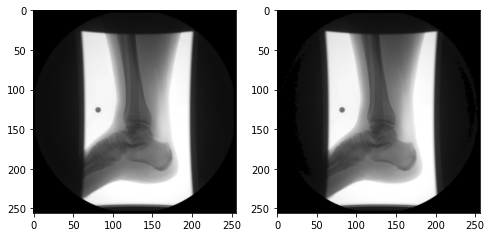

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

ax[0].imshow(train_imgs[5], cmap="gray")
ax[1].imshow(quantile_transformation(train_imgs[5], plot = False), cmap="gray")

plt.show()

A borda muito escura da imagem impossibilitou que a transformação das intensidades fosse feita segundo a pele e o osso do indivíduo, inviabilizando essa observação em específico quanto ao destaque da estrutura óssea do indivíduo. Um grande problema neste ponto é o fato dessa estrutura em torno da imagem ser composta principalmente por pixels com baixa variação de intensidade entre si, inviabilizando uma correção via quantização e correção por histogramas por exemplo, já que nesses métodos todos os pixels de uma determinada cor são mapeados para a mesma intensidade.

Uma solução mais válida seria a avaliação de realizarmos pontos de corte nas imagens de modo a desconsiderar essas regiões. Essa tarefa entretanto é complexa e pode ser computacionalmente custosa. Dado que a maior parte das imagens não sofre com esse problema optamos diretamente pela aplicação de diferentes transformações nas imagens, verificando em seguida aquelas que obtiveram o melhor desempenho quando usamos o classificador Bag of Features.

### Quantização e equalização por histograma

Vejamos os resultados do uso de uma transformação por meio de histogramas de intensidade automaticamente detectados por imagem. O método utilizado a seguir segue a mesma abordagem apresentada durante o curso de Processamento de Imagens.

In [14]:
def quantisation(img, B):
    """
    Realiza as etapas de sampling e quantização de uma imagem, simulando a sua digitalização.
    
    Input:
        img - Imagem a ser "digitalizada";
        N - Tamanho lateral N da imagem digital;
        B - Número de bits por pixel.
    """
    # Quantisation
    imin = np.min(img)
    imax = np.max(img)
    img = ( (img - imin) / (imax - imin) * (2**8 - 1) ).astype(np.uint8)
    
    img = img >> (8 - B)
    
    return img

def histogram(I, B):
    no_intensities = 2**B
    
    It = quantisation(I, B)
    
    hist = np.zeros(no_intensities).astype(int)
    for i in range(no_intensities):
        pixels_value_i = np.sum(It == i)
        hist[i] = pixels_value_i
            
    hist = hist/np.sum(hist)
    
    return It, hist

def histogram_equalization(I, B):
    
    M, N = I.shape
    
    no_intensities = 2**B
    
    It, h = histogram(I, B)
    hc = np.cumsum(h)
    
    L = no_intensities
    
    hc_dict = dict(zip(np.arange(no_intensities), hc))
    
    It_flat = It.flatten()
    
    imgt = np.array([ hc_dict.get(v) for v in It_flat ]).reshape((M,N))
    imgt *= (L-1) / (M*N)
    
    return imgt

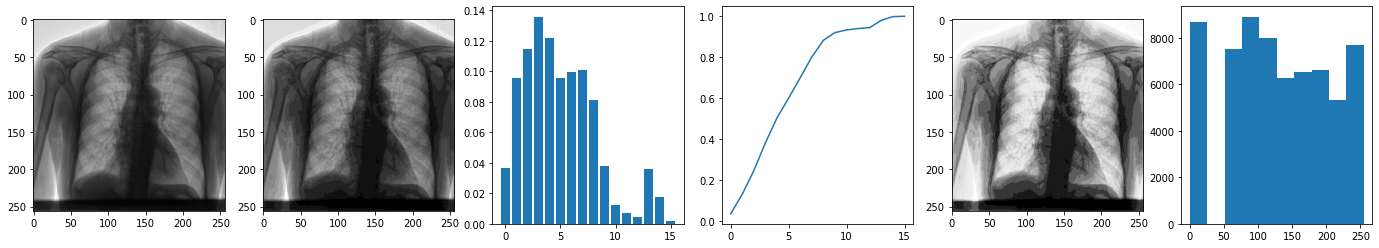

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 6, figsize = (24,4))

B = 4

img2_quantised, h = histogram(img2, B)
hc = np.cumsum(h)
img2_histogram_transformed = normalize(histogram_equalization(img2, B)).astype(np.uint8)

ax[0].imshow(img2, cmap = "gray")
ax[1].imshow(img2_quantised, cmap = "gray")
ax[2].bar(range(2**B), h)
ax[3].plot(range(2**B), hc)
ax[4].imshow(img2_histogram_transformed, cmap = "gray")
ax[5].hist(img2_histogram_transformed.flatten())

plt.show()

Veja que obtivemos de fato uma imagem mais clara, dada a alta concentração de pixels de baixa intensidade na imagem original. Essa abertura na distribuição de intensidades dos pixels pode levar a uma melhor significativa quando implementarmos a aplicação do classificador por Bag of Features.

# Segmentation por Watershed

In [16]:
import numpy as np

import imageio.v3 as imageio

from skimage import morphology
from skimage.segmentation import watershed
from skimage.segmentation import random_walker
from skimage.feature import peak_local_max
from scipy import ndimage

Vejamos alguns efeitos da aplicação do algoritmo de segmentação _Watershed_ nas imagens dos raios-X. Vejamos se obtemos padrões interessantes que possam contribuir positivamente na classificação das imagens.

In [17]:
def watershed_transformation(I, no_seeds, random_state = None):
    rd = np.random.RandomState(random_state)
    
    # Aplica a operação de edge-detection.
    img_dil = morphology.dilation(I, morphology.disk(1)).astype(np.uint8)
    img_ero = morphology.erosion(I, morphology.disk(1)).astype(np.uint8)
    img_grad = img_dil - img_ero

    # Define no_seeds sementes aleatórias
    random_seeds = np.zeros(I.shape)
    indices = rd.randint(0, I.shape[0], [no_seeds, 2])

    random_seeds[indices[:,0], indices[:,1]] = I[indices[:,0], indices[:,1]]
    random_seeds = morphology.dilation(random_seeds, morphology.disk(4)).astype(np.uint8)

    img_segment = watershed(img_grad, random_seeds)
    
    return img_segment

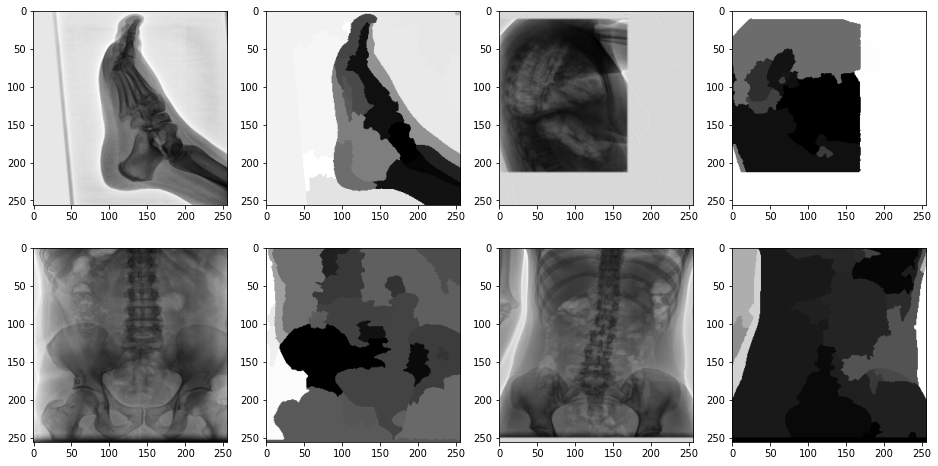

In [18]:
img1 = train_imgs[1]
img2 = train_imgs[6]
img3 = train_imgs[290]
img4 = train_imgs[130]

no_seeds = 25
img_segment1 = watershed_transformation(img1, no_seeds)
img_segment2 = watershed_transformation(img2, no_seeds)
img_segment3 = watershed_transformation(img3, no_seeds)
img_segment4 = watershed_transformation(img4, no_seeds)

# Plota as imagens.
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16,8))

ax[0,0].imshow(img1, cmap = "gray")
ax[0,1].imshow(img_segment1, cmap = "gray")

ax[0,2].imshow(img2, cmap = "gray")
ax[0,3].imshow(img_segment2, cmap = "gray")

ax[1,0].imshow(img3, cmap = "gray")
ax[1,1].imshow(img_segment3, cmap = "gray")

ax[1,2].imshow(img4, cmap = "gray")
ax[1,3].imshow(img_segment4, cmap = "gray")

plt.show()

Vemos que de fato os pés foram destacados na imagem, tendo alguns setores do fundo da imagem removidos. Ao olho humano o método parece simplificar estruturas de variação complexas como as costelas e simplificá-las com base nos principais componentes da região. Veja por exemplo que na imagem inferior a direita fica clara a distinção do osso da bacia em três grupos distintos detectados. Entretanto, veja também que a imagem inferior a esquerda, tratando o mesmo tipo de imagem, não  parece ter identificado uma estrutura inteligível ao olho humano.

# OTSU Thresholding

Uma outra abordagem para fazermos a segmentação das imagens foi a utilzação da binarização segundo o método de Otsu, que procura identificar o limiar ideal para a separação das intensidades dos pixels com base na minimização da variância interna dos grupos encontrados.

In [19]:
from skimage.filters import threshold_otsu

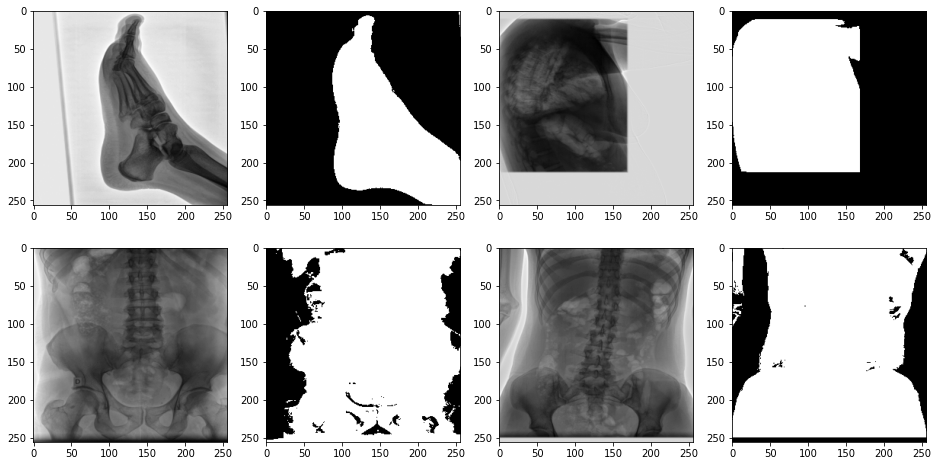

In [20]:
img1 = train_imgs[1]
img2 = train_imgs[6]
img3 = train_imgs[290]
img4 = train_imgs[130]

T1 = threshold_otsu(img1)
T2 = threshold_otsu(img2)
T3 = threshold_otsu(img3)
T4 = threshold_otsu(img4)

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16,8))

ax[0,0].imshow(img1, cmap = "gray")
ax[0,1].imshow(sliced_gray(img1, 0, T1, 255, method = 1, plot = False), cmap = "gray")

ax[0,2].imshow(img2, cmap = "gray")
ax[0,3].imshow(sliced_gray(img2, 0, T2, 255, method = 1, plot = False), cmap = "gray")

ax[1,0].imshow(img3, cmap = "gray")
ax[1,1].imshow(sliced_gray(img3, 0, T3, 255, method = 1, plot = False), cmap = "gray")

ax[1,2].imshow(img4, cmap = "gray")
ax[1,3].imshow(sliced_gray(img4, 0, T4, 255, method = 1, plot = False), cmap = "gray")

plt.show()

Veja que embora tenhamos um resultado interessante para o contorno do pé, boa parte das imagens é relativamente ruidosa, não sendo suficiente tratarmos a informação como valores binários. Desse modo é bem provável que os resultados da binarização pelo método de OTSU não seja suficiente.

## Bag of Features

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from imageio import imread
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from skimage import feature

import pydicom
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
from pydicom.uid import UID

import SimpleITK as sitk

from time import time

A seguir implementamos o código completo do algoritmo LBP utilizando como base os códigos fornecidos pelo professor e os monitores. A classe reúne as funções para a extração de características, assim como funções para a comparação da imagem de entrada (query) com as demais imagens do conjunto.

In [22]:
class LBP:
    def __init__(self,
                 random_state = 1,
                 patch_size = (11,11), n_patches = 250, # patches
                 lbp_radius = 2, lbp_sampling_pixels = 8, # lbp
                 n_dic = 50, 
                ):
        self.random_state = random_state
        self.patch_size = patch_size
        self.n_patches = n_patches
        self.lbp_radius = lbp_radius
        self.lbp_sampling_pixels = lbp_sampling_pixels
        self.n_dic = n_dic
    
    @staticmethod
    def _get_patches(image, random_state, patch_size, n_patches):
        img = normalize( image ).astype(np.uint8)
        
        # Extract subimages
        patch = extract_patches_2d(img,
                                   patch_size=patch_size,
                                   max_patches=n_patches, 
                                   random_state=random_state)

        if(len(img.shape) == 3):
            reshaped_patch = patch.reshape((n_patches, np.prod( patch_size ) * img.shape[2] ))
        else:
            reshaped_patch = patch.reshape((n_patches, np.prod( patch_size ) ))

        return reshaped_patch
    
    @staticmethod
    def _lbp_features(img, radius=1, sampling_pixels=8):
        
        # LBP operates in single channel images so if RGB images are provided     
        # we have to convert it to grayscale
        if (len(img.shape) > 2):
            img = img.astype(float)
            # RGB to grayscale convertion using Luminance
            img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

        # converting to uint8 type for 256 graylevels
        img = img.astype(np.uint8)

        # normalize values can also help improving description
        i_min = np.min(img)
        i_max = np.max(img)
        if (i_max - i_min != 0):
            img = (img - i_min)/(i_max-i_min)

        # compute LBP
        lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")

        # LBP returns a matrix with the codes, so we compute the histogram
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

        # normalization
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        # return the histogram of Local Binary Patterns
        return hist
    
    def get_patches(self, images):
        self.images = images
        self.n_imgs = len(images)
        patch_arr = Parallel(n_jobs=-1)(delayed(LBP._get_patches)(
            image, 
            self.random_state,
            self.patch_size,
            self.n_patches) for image in images)
        self.patch_arr = np.array(patch_arr)
    
    def fit(self):
        total_patches = self.patch_arr.reshape((self.patch_arr.shape[0] * self.patch_arr.shape[1], self.patch_size[0],
                                                self.patch_size[0]))

        # --- Obtaining features lbp for each patch ---
        patch_lbp = []
        for pat in total_patches:
            f = LBP._lbp_features(pat, self.lbp_radius, self.lbp_sampling_pixels)
            patch_lbp.append(f)
        self.patch_lbp = np.array(patch_lbp)
        
        # --- Learning dictionary ---
        
        # Define a KMeans clustering model
        self.kmeans_model = KMeans(n_clusters=self.n_dic, 
                              verbose=False, 
                              init='random',
                              random_state=self.random_state, 
                              n_init=3)
        # fit the model
        self.kmeans_model.fit(patch_lbp)
        
        # --- Histograms of Bag of Features ---
        
        # compute features for each image
        img_feats = []
        for i in range(self.n_imgs):
            # predicting n_patches of an image
            y = self.kmeans_model.predict(patch_lbp[(i*self.n_patches):(i*self.n_patches+self.n_patches)])

            # computes histogram and append in the array
            hist_bof,_ = np.histogram(y, bins=range(self.n_dic+1), density=True)
            img_feats.append(hist_bof)

        self.img_feats = np.array(img_feats, copy=False)
    
    def recognition(self, queryImage, queryIndex, plot = False):
        # get query patches
        query_patches = np.array( LBP._get_patches(queryImage, self.random_state, self.patch_size, self.n_patches) )

        query_patches = query_patches.reshape((query_patches.shape[0],
                                       self.patch_size[0],self.patch_size[0]))

        # get LBP feathres
        query_lbp = []
        for pat in query_patches:
                f = LBP._lbp_features(pat, self.lbp_radius, self.lbp_sampling_pixels)
                query_lbp.append(f)

        query_lbp = np.array(query_lbp, copy=False)

        # get visual words for query
        y = self.kmeans_model.predict(query_lbp)
        # computes descriptor
        query_feats,_ = np.histogram(y, bins=range(self.n_dic+1), density=True)

        # computes distances
        dists = []
        for i in range(self.n_imgs):
            diq = np.sqrt(np.sum( (self.img_feats[i] - query_feats)**2 ))
            dists.append(diq)

        # check the nearest images
        k = 8
        k_cbir = np.argsort(dists)[:k]
        
        if(plot):
            plt.figure(figsize=(12,8))
            plt.subplot(331); plt.imshow(test_imgs[queryIndex], cmap="gray")
            plt.title('Query'); plt.axis('off')

            imgs = []
            for i in range(k):
                imgs.append(train_imgs[k_cbir[i]])
                plt.subplot(3,3,i+2); plt.imshow(imgs[i], cmap="gray")
                plt.title('%d, %.4f' % (i, dists[k_cbir[i]])); plt.axis('off')
            
        return k_cbir

In [ ]:
#sliced_gray(I, A, B, L, method = 0, plot = True)
A = 100
B = 200
L = 255

# --- Method 1 - Binary ---
binary_train_imgs = np.array([sliced_gray(train_imgs[j], A, B, L, method = 1, plot = False).astype(np.uint8) for j in range(train_imgs.shape[0])])
binary_test_imgs = np.array([sliced_gray(test_imgs[j], A, B, L, method = 1, plot = False).astype(np.uint8) for j in range(test_imgs.shape[0])])

# --- Method 2 - Identity ---
identity_train_imgs = np.array([sliced_gray(train_imgs[j], A, B, L, method = 2, plot = False).astype(np.uint8) for j in range(train_imgs.shape[0])])
identity_test_imgs = np.array([sliced_gray(test_imgs[j], A, B, L, method = 2, plot = False).astype(np.uint8) for j in range(test_imgs.shape[0])])

# --- Method 3 - Negative ---
negative_train_imgs = np.array([sliced_gray(train_imgs[j], A, B, L, method = 3, plot = False).astype(np.uint8) for j in range(train_imgs.shape[0])])
negative_test_imgs = np.array([sliced_gray(test_imgs[j], A, B, L, method = 3, plot = False).astype(np.uint8) for j in range(test_imgs.shape[0])])

# --- Method 4 - Quantile Transformation ---
quantile_train_imgs = np.array([quantile_transformation(train_imgs[j], plot = False).astype(np.uint8) for j in range(train_imgs.shape[0])])
quantile_test_imgs = np.array([quantile_transformation(test_imgs[j], plot = False).astype(np.uint8) for j in range(test_imgs.shape[0])])

# --- Method 5 - Watershed ---
watershed_train_imgs = np.array([ watershed_transformation(train_imgs[j], 25) for j in range(train_imgs.shape[0]) ])
watershed_test_imgs = np.array([ watershed_transformation(test_imgs[j], 25) for j in range(test_imgs.shape[0]) ])
    
# Número de bytes para a quantização da imagem no histograma
b = 4
# --- Method 6 - Histogram transform ---
histogram_train_imgs = np.array([ normalize(histogram_equalization(train_imgs[j], b)).astype(np.uint8) for j in range(train_imgs.shape[0]) ])
histogram_test_imgs = np.array([ normalize(histogram_equalization(test_imgs[j], b)).astype(np.uint8) for j in range(test_imgs.shape[0]) ])

In [24]:
lbp_params = {"random_state" : 4,
    "patch_size" : (15,15),
    "n_patches": 250,
    "lbp_radius":2,
    "lbp_sampling_pixels" : 8,
    "n_dic" : 100}

start = time()

# LBP - Original
lbp_original = LBP(**lbp_params)
lbp_original.get_patches(train_imgs)
lbp_original.fit()

print("Original Elapsed:", time() - start)

# LBP - Binary
start = time()

lbp_binary = LBP(**lbp_params)
lbp_binary.get_patches(binary_train_imgs)
lbp_binary.fit()

print("Binary Elapsed:", time() - start)

start = time()

# LBP - Identity
lbp_identity = LBP(**lbp_params)
lbp_identity.get_patches(identity_train_imgs)
lbp_identity.fit()

print("Identity Elapsed:", time() - start)

start = time()

# LBP - Negative
lbp_negative = LBP(**lbp_params)
lbp_negative.get_patches(negative_train_imgs)
lbp_negative.fit()

print("Negative Elapsed:", time() - start)

start = time()

# LBP - Quantile
lbp_quantile = LBP(**lbp_params)
lbp_quantile.get_patches(quantile_train_imgs)
lbp_quantile.fit()

print("Quantile Elapsed:", time() - start)

start = time()

# LBP - Watershed
lbp_watershed = LBP(**lbp_params)
lbp_watershed.get_patches(watershed_train_imgs)
lbp_watershed.fit()

print("Watershed Elapsed:", time() - start)

start = time()

# LBP - Histogram
lbp_histogram = LBP(**lbp_params)
lbp_histogram.get_patches(histogram_train_imgs)
lbp_histogram.fit()

print("Histogram Elapsed:", time() - start)

Original Elapsed: 72.64666557312012
Binary Elapsed: 69.79355263710022
Identity Elapsed: 67.47892427444458
Negative Elapsed: 69.58599925041199
Quantile Elapsed: 66.56787919998169
Watershed Elapsed: 67.67343258857727
Histogram Elapsed: 71.21743559837341


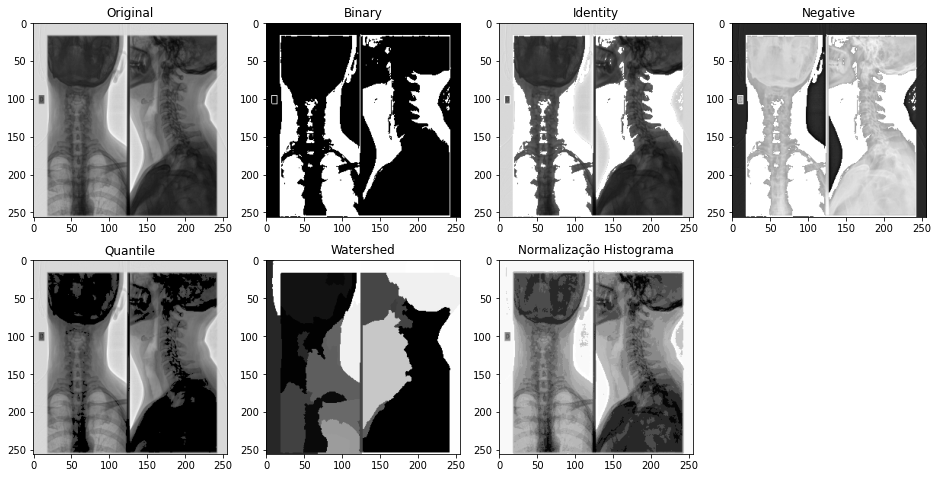

In [34]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16,8))

j = 0
img = train_imgs[j]
binary_img = binary_train_imgs[j]
identity_img = identity_train_imgs[j]
negative_img = negative_train_imgs[j]
quantile_img = quantile_train_imgs[j]
watershed_img = watershed_train_imgs[j]
histogram_img = histogram_train_imgs[j]

ax[0,0].imshow(img, cmap = "gray")
ax[0,0].set_title("Original")
ax[0,1].imshow(binary_img, cmap = "gray")
ax[0,1].set_title("Binary")
ax[0,2].imshow(identity_img, cmap = "gray")
ax[0,2].set_title("Identity")
ax[0,3].imshow(negative_img, cmap = "gray")
ax[0,3].set_title("Negative")
ax[1,0].imshow(quantile_img, cmap = "gray")
ax[1,0].set_title("Quantile")
ax[1,1].imshow(watershed_img, cmap = "gray")
ax[1,1].set_title("Watershed")
ax[1,2].imshow(histogram_img, cmap = "gray")
ax[1,2].set_title("Normalização Histograma")

fig.delaxes(ax[1,3])

plt.show()

In [39]:
def recognition_method(queryIndex, method = 0, plot = False):
    dic = {0:"Original", 1:"Binary", 2:"Identity", 3:"Negative", 4:"Quantile", 5:"Watershed", 6:"Quantile Watershed"}
    # print("Método: {}".format(dic[method]))
    
    if method == 0: 
        imgQuery = test_imgs[queryIndex]
        indices = lbp_original.recognition(imgQuery, queryIndex, plot = plot)
        
    elif method == 1: 
        imgQuery = binary_test_imgs[queryIndex]
        indices = lbp_binary.recognition(imgQuery, queryIndex, plot = plot)
        
    elif method == 2: 
        imgQuery = identity_test_imgs[queryIndex]
        indices = lbp_identity.recognition(imgQuery, queryIndex, plot = plot)
        
    elif method == 3: 
        imgQuery = negative_test_imgs[queryIndex]
        indices = lbp_negative.recognition(imgQuery, queryIndex, plot = plot)
        
    elif method == 4: 
        imgQuery = quantile_test_imgs[queryIndex]
        indices = lbp_quantile.recognition(imgQuery, queryIndex, plot = plot)
        
    elif method == 5: 
        imgQuery = watershed_test_imgs[queryIndex]
        indices = lbp_watershed.recognition(imgQuery, queryIndex, plot = plot)
        
    elif method == 6: 
        imgQuery = histogram_test_imgs[queryIndex]
        indices = lbp_histogram.recognition(imgQuery, queryIndex, plot = plot)
    return list(indices)

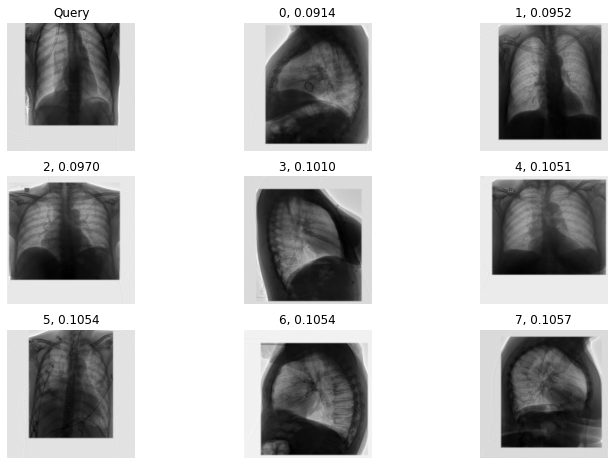

In [36]:
indices = recognition_method(0, method = 0, plot = True)

In [37]:
stats.mode(train_label_names[indices])[0][0]

'Chest'

Veja que para esse caso em particular a imagem do teste (Query) foi de fato classificada corretamente. Façamos uma estrutura para a classificação de todas as imagens do conjunto de teste.

# Estabelecendo o modelo de classificação

In [40]:
def classify(indices):    
    if(type(indices[0]) == list):
        _classes = []
        print(indices)
        for index in indices:
            _classes.append( stats.mode(train_label_names[index])[0][0] )
        return _classes
    
    return stats.mode(train_label_names[indices])[0][0]

In [41]:
# Percorre os índices do teste aplicando a classificação da imagem segundo as imagens similares

# Original
test_label_pred0 = np.array([ classify( recognition_method(j, method = 0) ) for j in range(test_imgs.shape[0]) ])

# --- Method 1 - Binary ---
test_label_pred1 = np.array([ classify( recognition_method(j, method = 1) ) for j in range(test_imgs.shape[0]) ])

# --- Method 2 - Identity ---
test_label_pred2 = np.array([ classify( recognition_method(j, method = 2) ) for j in range(test_imgs.shape[0]) ])

# --- Method 3 - Negative ---
test_label_pred3 = np.array([ classify( recognition_method(j, method = 3) ) for j in range(test_imgs.shape[0]) ])

# --- Method 4 - Quantile Transformation ---
test_label_pred4 = np.array([ classify( recognition_method(j, method = 4) ) for j in range(test_imgs.shape[0]) ])

# --- Method 5 - Watershed ---
test_label_pred5 = np.array([ classify( recognition_method(j, method = 5) ) for j in range(test_imgs.shape[0]) ])

# --- Method 6 - Quantile followed by Watershed ---
test_label_pred6 = np.array([ classify( recognition_method(j, method = 6) ) for j in range(test_imgs.shape[0]) ])

In [43]:
print("Acurácia imagens originais:", np.round(np.mean(test_label_pred0 == test_label_names), 4))
print("Acurácia imagens binárias:", np.round(np.mean(test_label_pred1 == test_label_names), 4))
print("Acurácia transformação com identidade:", np.round(np.mean(test_label_pred2 == test_label_names), 4))
print("Acurácia transformação com negativo:", np.round(np.mean(test_label_pred3 == test_label_names), 4))
print("Acurácia transformação quantílica:", np.round(np.mean(test_label_pred4 == test_label_names), 4))
print("Acurácia watershed:", np.round(np.mean(test_label_pred5 == test_label_names), 4))
print("Acurácia normalização por histograma:", np.round(np.mean(test_label_pred6 == test_label_names), 4))

Acurácia imagens originais: 0.5967
Acurácia imagens binárias: 0.4967
Acurácia transformação com identidade: 0.5833
Acurácia transformação com negativo: 0.59
Acurácia transformação quantílica: 0.63
Acurácia watershed: 0.4667
Acurácia normalização por histograma: 0.5433


In [57]:
# Distribuição das labels no conjunto de teste
pd.Series(test_label_names).value_counts()/len(test_label_names)

Chest             0.436667
Others            0.083333
Knee              0.053333
Abdomen           0.050000
Wrist             0.046667
Cervical Spine    0.043333
Lumbar Spine      0.040000
Pelvis            0.033333
Hand              0.026667
Ankle             0.026667
Forearm           0.023333
Hip               0.023333
Feet              0.023333
Shoulder          0.016667
Lower Leg         0.013333
Sinus             0.013333
Elbow             0.010000
Skull             0.010000
Thigh             0.010000
Thoracic Spine    0.010000
Clavicles         0.003333
Finger            0.003333
dtype: float64

Obtivemos um resultado relativamente satisfatório para a classificação das imagens. Considerando que temos 22 classes de imagens e que a classe mais comum é "Chest", com 43.67% de ocorrências, temos um resultado relativamente superior ao esperado por um modelo trivial, com o melhor desempenho sendo associado à classificação segundo as imagens com transformação quantílica, proposta pela equipe para a aplicação da classificação.

# Muda as imagens de DCM para JPG

In [15]:

from matplotlib import pyplot as plt

#Treino
#for path in ["train_images/"+path for path in os.listdir("train_images")][:1]:
#    img=pydicom.dcmread(path, force = True).pixel_array
#    plt.imsave("train_images_jpg/"+path[13:-4]+".jpg", img, cmap = "gray")

#Teste
#for path in ["test_images/"+path for path in os.listdir("test_images")]:
#    img=pydicom.dcmread(path, force = True).pixel_array
#    plt.imsave("test_images_jpg/"+path[12:-4]+".jpg", img, cmap = "gray")
    
#Não sei pq, mas o jpg salva as imagens como tendo cor...

In [16]:
#for path in ["train_images_jpg/"+path for path in os.listdir("train_images_jpg")][:1]:
#    img=(plt.imread(path))[:,:,0]
    #img = img[:,:,0]
#    plt.imshow(img)
#    print(img)
#    print(img.shape)